In [1]:
import os
import pandas
import numpy
import math
import matplotlib
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import RidgeCV

In [2]:
# Settings
filename = "MA_Public_Schools_2017.csv"
start_year = 2010
stop_year = 2017
y_column_name = "% Graduated"
ignore_columns = [
    "High School Graduates (#)",
    "% Dropped Out",
    "% Still in School",
    "School Code",
    "School Name",
    "Contact Name",
    "Address 1",
    "Address 2",
    "Town",
    "State",
    "Zip",
    "Phone",
    "Fax",
    "District Name",
    "% Still in School",
    "% Non-Grad Completers",
    "% GED",
    "% Dropped Out",
    "% Permanently Excluded",
    "High School Graduates (#)",
    "Attending Coll./Univ. (#)",
    "Accountability and Assistance Description",
    "District_Accountability and Assistance Description",
]
floatify_columns = ["AP_Test Takers", "AP_Tests Taken"]
levelize_columns = ["Accountability and Assistance Level", "District_Accountability and Assistance Level"]
gradify_columns = ["Grade"]

In [3]:
# Load the data
df = pandas.read_csv(filename)

In [4]:
df

,School Code,School Name,School Type,Function,Contact Name,Address 1,Address 2,Town,State,Zip,...,MCAS_10thGrade_English_Incl. in SGP(#),Accountability and Assistance Level,Accountability and Assistance Description,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Accountability and Assistance Level,District_Accountability and Assistance Description,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students
0,10505,Abington High,Public School,Principal,Teresa Sullivan-Cruz,201 Gliniewicz Way,NaN,Abington,MA,2351,...,111.0,Level 1,Meeting gap narrowing goals,42.0,76.0,75.0,Level 3,One or more schools in the district classified...,63.0,60.0
1,10003,Beaver Brook Elementary School,Public School,Principal,Catherine Zinni,1 Ralph Hamlin Lane,NaN,Abington,MA,2351,...,NaN,Level 3,Among lowest performing 20% of subgroups,34.0,69.0,73.0,Level 3,One or more schools in the district classified...,63.0,60.0
2,10002,Center Elementary School,Public School,Principal,Lora Monachino,201 Gliniewicz Way,NaN,Abington,MA,2351,...,NaN,Insufficient data,NaN,NaN,NaN,NaN,Level 3,One or more schools in the district classified...,63.0,60.0
3,10405,Frolio Middle School,Public School,Principal,Matthew MacCurtain,201 Gliniewicz Way,NaN,Abington,MA,2351,...,NaN,Level 2,Not meeting gap narrowing goals,40.0,63.0,64.0,Level 3,One or more schools in the district classified...,63.0,60.0
4,10015,Woodsdale Elementary School,Public School,Principal,Jonathan Hawes,128 Chestnut Street,NaN,Abington,MA,2351,...,NaN,Level 2,Not meeting gap narrowing goals,52.0,65.0,67.0,Level 3,One or more schools in the district classified...,63.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,35060505,Pioneer Charter School of Science II (PCSS-II),Charter School,Principal,Vahit Sevinc,97 Main Street,NaN,Saugus,MA,1906,...,30.0,Insufficient data,NaN,NaN,NaN,NaN,Insufficient data,NaN,NaN,NaN
1857,35100205,Springfield Preparatory Charter School,Charter School,Principal,Bill Spirer,370 Pine St.,NaN,Springfield,MA,1105,...,NaN,Insufficient data,NaN,NaN,NaN,NaN,Insufficient data,NaN,NaN,NaN
1858,39020900,TEC Connections Academy Commonwealth Virtual S...,Public School,Principal,Adam Goldberg,141 Mansion Drive,NaN,East Walpole,MA,2032,...,28.0,Level 3,Very low assessment participation (Less than 90%),NaN,NaN,NaN,Level 3,Very low assessment participation (Less than 90%),NaN,NaN
1859,35050405,UP Academy Charter School of Dorchester,Charter School,Principal,Jabari Peddie,35 Westville Street,NaN,Boston,MA,2124,...,NaN,Level 1,Meeting gap narrowing goals,35.0,92.0,98.0,Level 1,Meeting gap narrowing goals,92.0,98.0


In [5]:
df[y_column_name].describe()

count    376.000000
mean      83.327394
std       21.459396
min        0.000000
25%       82.150000
50%       92.250000
75%       96.200000
max      100.000000
Name: % Graduated, dtype: float64

In [6]:
df[y_column_name].isna().sum()

1485

In [7]:
# Get rid of errored/confusing data
df_slim = df
for column in ignore_columns:
    if column in df_slim.columns:
        df_slim = df_slim.drop(column, 1)

In [8]:
# Columns that were removed
for column in df.columns:
    if column not in df_slim.columns:
        print(column)

School Code
School Name
Contact Name
Address 1
Address 2
Town
State
Zip
Phone
Fax
District Name
% Still in School
% Non-Grad Completers
% GED
% Dropped Out
% Permanently Excluded
High School Graduates (#)
Attending Coll./Univ. (#)
Accountability and Assistance Description
District_Accountability and Assistance Description


In [9]:
df_slim.isna().sum().sum()

368130

In [10]:
# Fix Data
df_clean = df_slim

for column in floatify_columns:
    for row in range(df_clean.shape[0]):
        if type(df_clean.loc[row, column]) is str:
            df_clean.loc[row, column] = float(df_clean.loc[row, column].replace(',', ''))

for column in levelize_columns:
    for row in range(df_clean.shape[0]):
        value = df_clean.loc[row, column]
        if value == "Insufficient data":
            df_clean.loc[row, column] = None
        elif value == "Level 1":
            df_clean.loc[row, column] = 1
        elif df_clean.loc[row, column] == "Level 2":
            df_clean.loc[row, column] = 2
        elif df_clean.loc[row, column] == "Level 3":
            df_clean.loc[row, column] = 3
        elif df_clean.loc[row, column] == "Level 4":
            df_clean.loc[row, column] = 4
        elif df_clean.loc[row, column] == "Level 5":
            df_clean.loc[row, column] = 5

grades = ["PK", "K", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

for grade in grades:
    df_clean["Grade " + grade] = numpy.full(df_clean.shape[0], 0)

for column in gradify_columns:
    for row in range(df_clean.shape[0]):
        if type(df_clean.loc[row, column]) is not float:
            for current_grade in df_clean.loc[row, column].replace("0", "").split(","):
                df_clean.loc[row, "Grade " + current_grade] = 1

In [11]:
# Fix NA's
df_no_na = df_clean.fillna(df_clean.mean()).fillna(df_clean.mode()).dropna(1)

In [12]:
# Columns that were removed
for column in df_slim.columns:
    if column not in df_no_na.columns:
        print(column)

Grade
AP_Test Takers
AP_Tests Taken
MCAS_3rdGrade_Math_SGP
MCAS_3rdGrade_Math_Incl. in SGP(#)
MCAS_3rdGrade_English_SGP
MCAS_3rdGrade_English_Incl. in SGP(#)
Accountability and Assistance Level
District_Accountability and Assistance Level


In [13]:
# Select only features that impact the R^2
df_selected_features = df_no_na

changed = True

x = df_selected_features.drop(y_column_name, 1)
y = df_selected_features[y_column_name]

x_encoded = x.apply(LabelEncoder().fit_transform)

x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2)

model = RidgeCV()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

r_2 = r2_score(y_test, y_pred)

r_2s = [r_2]

current = 0
end = df_selected_features.shape[1]

while df_selected_features.shape[1] > 2 and current < end:
    features = df_selected_features.columns.drop(y_column_name)
    current_feature = features[len(features) - 1]
    df_features_this_loop = df_selected_features.drop(current_feature, 1)

    x = df_features_this_loop.drop(y_column_name, 1)
    y = df_features_this_loop[y_column_name]

    x_encoded = x.apply(LabelEncoder().fit_transform)

    x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2)

    model = RidgeCV()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    current_r_2 = r2_score(y_test, y_pred)

    if r_2 - current_r_2 < 0.03:
        r_2 = current_r_2
        df_selected_features = df_features_this_loop
        end -= 1
        r_2s.append(current_r_2)

    current += 1

[]

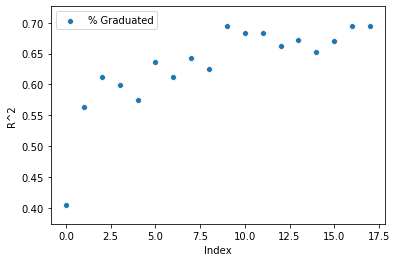

In [14]:
matplotlib.pyplot.figure()
seaborn.scatterplot(y="R^2", x="Index", label=y_column_name, data=pandas.DataFrame({"R^2": r_2s, "Index": range(len(r_2s))})).plot()

In [15]:
# Columns that were removed
for column in df_clean.columns:
    if column not in df_selected_features.columns:
        print(column)

Grade
AP_Test Takers
AP_Tests Taken
MCAS_3rdGrade_Math_SGP
MCAS_3rdGrade_Math_Incl. in SGP(#)
MCAS_3rdGrade_English_SGP
MCAS_3rdGrade_English_Incl. in SGP(#)
Accountability and Assistance Level
Progress and Performance Index (PPI) - High Needs Students
District_Accountability and Assistance Level
District_Progress and Performance Index (PPI) - All Students
District_Progress and Performance Index (PPI) - High Needs Students
Grade PK
Grade K
Grade 1
Grade 2
Grade 3
Grade 4
Grade 5
Grade 6
Grade 7
Grade 8
Grade 9
Grade 10
Grade 11
Grade 12


In [16]:
# Split data
x = df_selected_features.drop(y_column_name, 1)
y = df_selected_features[y_column_name]

x_encoded = x.apply(LabelEncoder().fit_transform)

x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2)

In [17]:
# Ridge Regression
model = RidgeCV()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [18]:
# R^2
print(r2_score(y_test, y_pred))

0.4047185563978667


In [19]:
# Selected Columns
columns = []
coefficients = []
for index in range(len(model.coef_)):
    if model.coef_[index] > 0:
        columns.append(x_train.columns[index])
        coefficients.append(model.coef_[index])

coefficients_sorted = pandas.DataFrame({"Column": columns, "Coefficient": coefficients}).sort_values("Coefficient", ascending=False)

for index in range(coefficients_sorted.shape[0]):
    print("{0:<100.100}: {1:4.4f}".format(coefficients_sorted.iloc[index, 0], coefficients_sorted.iloc[index, 1]))

% MCAS_10thGrade_Math_P+A                                                                           : 3.0115
% MCAS_10thGrade_Math_NI                                                                            : 1.4628
% MCAS_10thGrade_Math_W/F                                                                           : 1.3681
% MCAS_7thGrade_Math_W/F                                                                            : 1.1253
% MCAS_8thGrade_English_P+A                                                                         : 0.9839
MCAS_8thGrade_English_Incl. in SGP(#)                                                               : 0.9625
% Females                                                                                           : 0.8103
MCAS_8thGrade_Math_P+A #                                                                            : 0.8071
% Males                                                                                             : 0.8017
% MCAS_8thGrade_Mat

In [20]:
# Neural Network Regressor
model = MLPRegressor(max_iter=400)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [21]:
# R^2
print(r2_score(y_test, y_pred))

0.18148012789231727


In [22]:
# Ada Boost Regression
model = AdaBoostRegressor()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [23]:
# R^2
print(r2_score(y_test, y_pred))

0.6563068371865504


In [24]:
columns = []
importances = []
for index in range(len(model.feature_importances_)):
    if model.feature_importances_[index] > 0.01:
        columns.append(x_train.columns[index])
        importances.append(model.feature_importances_[index])

importance_sorted = pandas.DataFrame({"Column": columns, "Importance": importances}).sort_values("Importance", ascending=False)

for index in range(importance_sorted.shape[0]):
    print("{0:<100.100}: {1:4.4f}".format(importance_sorted.iloc[index, 0], importance_sorted.iloc[index, 1]))

% High Needs                                                                                        : 0.1303
% Females                                                                                           : 0.1012
% Hispanic                                                                                          : 0.0794
SAT_Tests Taken                                                                                     : 0.0766
# in Cohort                                                                                         : 0.0724
10_Enrollment                                                                                       : 0.0617
Average Class Size                                                                                  : 0.0450
District Code                                                                                       : 0.0412
% White                                                                                             : 0.0317
MCAS_10thGrade_Math

In [25]:
important_columns = []
for column in importance_sorted["Column"]:
    important_columns.append(column)
important_columns.append(y_column_name)
df_important = df_selected_features[important_columns]

In [26]:
# Split data
x = df_important.drop(y_column_name, 1)
y = df_important[y_column_name]

x_encoded = x.apply(LabelEncoder().fit_transform)

x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2)

In [27]:
# Ada Boost Regression
model = AdaBoostRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [28]:
# R^2
print(r2_score(y_test, y_pred))

0.5061966638084192
